In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone
import os
import sys

# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import SplitFeatures as sf
from src.features import FeaturePlots as featplot

This notebook examines the difference between temporal and event based splitting of the feature datasets into training and testing datasets. It was used to develop the functions in features.py and the script make_feature_splits.py, which actually writes the datasets split with the event based method to disk. 

In [ ]:
data_path = '../../data'
p_feats = pd.read_csv(f'{data_path}/features/p_features.2024.csv')
s_feats = pd.read_csv(f'{data_path}/features/s_features.2024.csv')

In [3]:
ev_cat = pd.read_csv(f'{data_path}/catalogs/yellowstone.events.ypml-v5.2024.csv')
arr_cat = pd.read_csv(f'{data_path}/catalogs/yellowstone.arrivals.gains.2024.csv')
arr_cat = arr_cat[arr_cat['evid'].isin(ev_cat['Evid'].unique())]
ev_cat['Date'] = pd.to_datetime(ev_cat['Date'], format='mixed')

In [4]:
sf.print_feature_df_event_counts(p_feats, "P", ev_cat)
sf.print_feature_df_event_counts(s_feats, "S", ev_cat)

There are 7996 events and 92295 arrivals in the P feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2023-12-29 09:38:37.689999+00:00
There are 7017 events and 18179 arrivals in the S feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2023-12-29 09:38:37.689999+00:00


In [5]:
p_ev = sf.get_feature_event_info(p_feats, ev_cat)
s_ev = sf.get_feature_event_info(s_feats, ev_cat, 'S')

P event count: 7995
S event count: 7016


In [6]:
p_feats = sf.add_YP21_magnitude_to_features(p_feats, p_ev)
s_feats = sf.add_YP21_magnitude_to_features(s_feats, s_ev, 'S')


The original number of P features: 92295 (7996 events) 
The number of P features with a YP21 mag: 92288 (7995 events)
The original number of S features: 18179 (7017 events) 
The number of S features with a YP21 mag: 18177 (7016 events)


# Choose suitable temporal split

In [7]:
train_frac = 0.8

In [8]:
p_ev.iloc[int(p_ev.shape[0]*train_frac)]["Date"]

Timestamp('2021-07-26 03:43:21.160000+0000', tz='UTC')

In [9]:
s_ev.iloc[int(s_ev.shape[0]*train_frac)]["Date"]

Timestamp('2021-08-20 17:23:15.259999+0000', tz='UTC')

2021/8/1 looks like a reasonable temporal cut off based off the entire dataset

In [10]:
train_cutoff = datetime(2021, 8, 1, tzinfo=timezone.utc) #np.datetime64('2020-07-01')

# Do temporal split

In [11]:
p_train_evids, p_test_evids = sf.date_train_test_split(p_ev, train_cutoff)
s_train_evids, s_test_evids = sf.date_train_test_split(s_ev, train_cutoff)
p_train_feats, p_test_feats = sf.get_features_by_evid(p_feats, p_train_evids, p_test_evids)
s_train_feats, s_test_feats = sf.get_features_by_evid(s_feats, s_train_evids, s_test_evids)
sf.print_split_percentage(p_train_evids, p_ev)
sf.print_split_percentage(s_train_evids, s_ev, phase='S')


P Train size: 80.16 %
S Train size: 79.77 %


# Set the minimum training and test sizes for each P and S station
Uses the train_frac variable set above

In [12]:
p_min_train = 300
s_min_train = 150

p_min_test = sf.compute_min_test_examples(p_min_train, train_frac)
s_min_test = sf.compute_min_test_examples(s_min_train, train_frac, phase='S')

P train min: 300, test min: 75, total example min: 375
S train min: 150, test min: 38, total example min: 188


# Look into the number of stations meeting minimum requirements with a temporal split

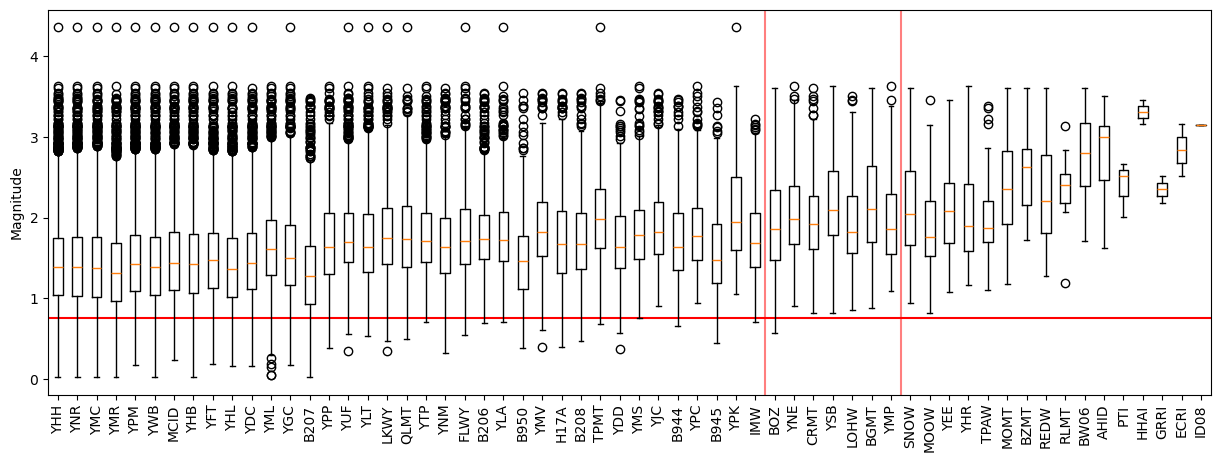

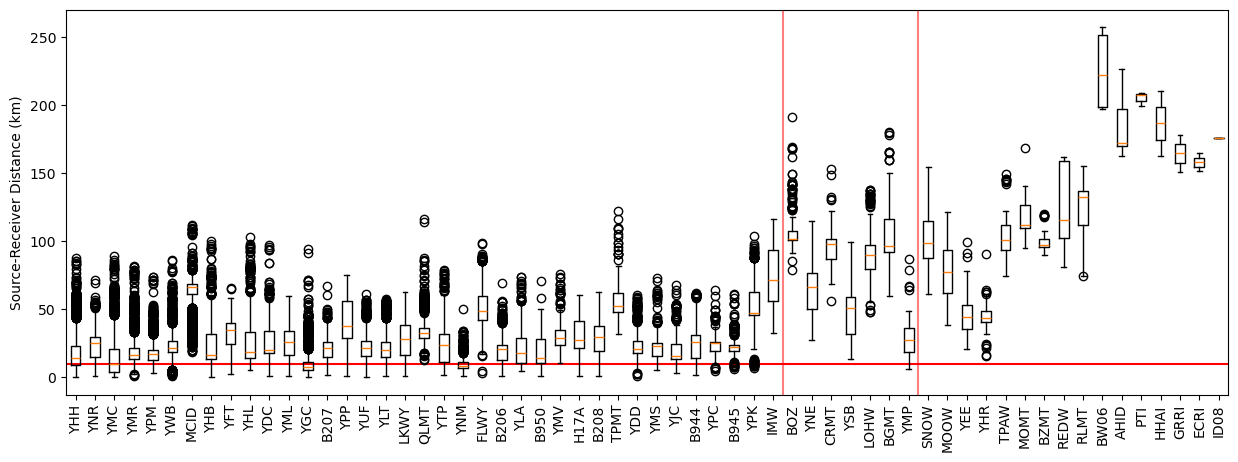

In [13]:
featplot.plot_station_feature_box_whisker(p_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=0.75)
featplot.plot_station_feature_box_whisker(p_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

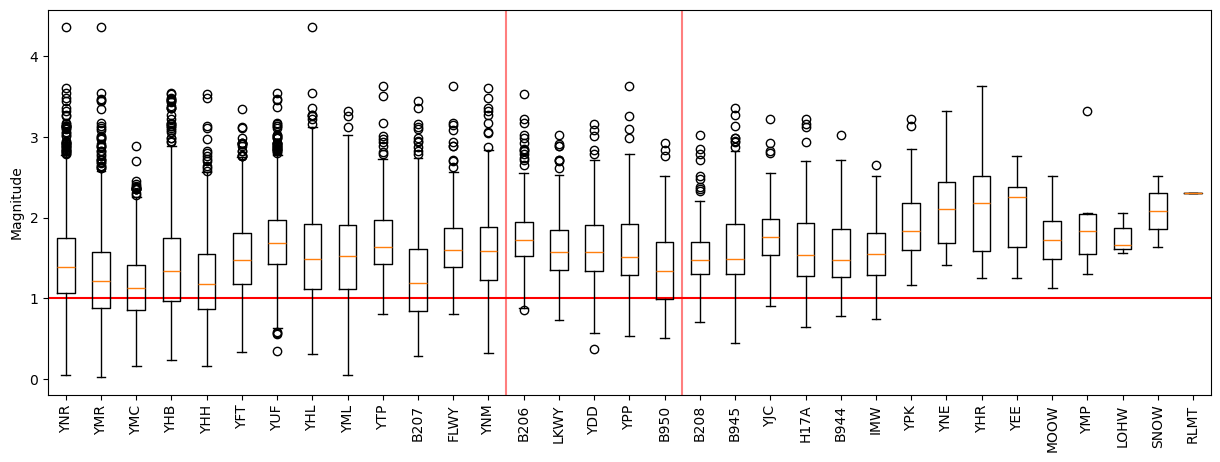

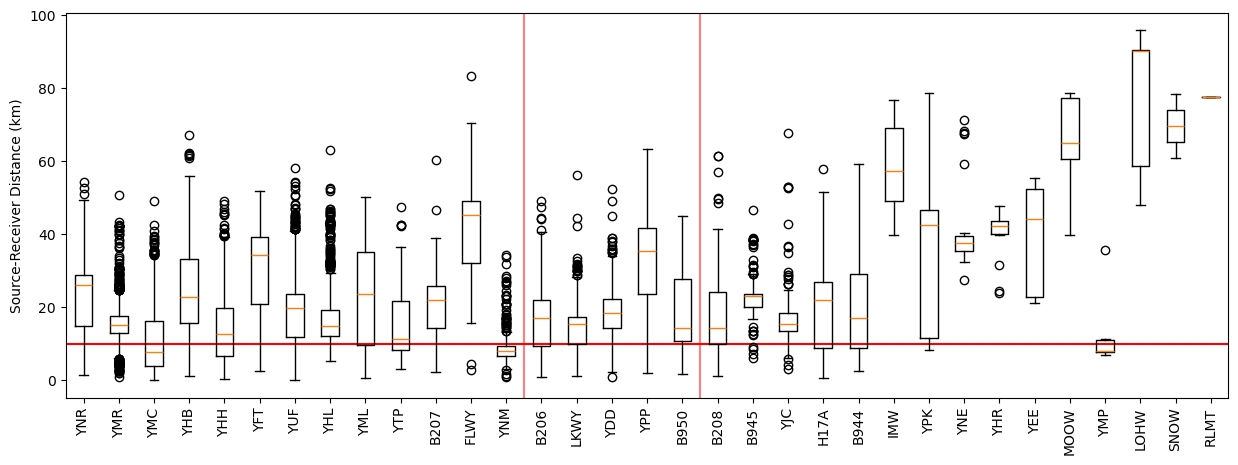

In [14]:
featplot.plot_station_feature_box_whisker(s_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=1.0)
featplot.plot_station_feature_box_whisker(s_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

In [15]:
p_counts = sf.get_station_train_test_counts(p_train_feats, p_test_feats)
s_counts = sf.get_station_train_test_counts(s_train_feats, s_test_feats)

p_good_stats = sf.get_stations_with_min_examples(p_counts, p_min_train, p_min_test)
s_good_stats = sf.get_stations_with_min_examples(s_counts, s_min_train, s_min_test, 'S')

p_almost_stats = sf.get_stations_close_to_criteria(p_counts, p_min_train, p_min_test)
s_almost_stats = sf.get_stations_close_to_criteria(s_counts, s_min_train, s_min_test, 'S')

P stations meeting the min. criteria: 29
S stations meeting the min. criteria: 13
P stations close to min. criteria: 9
S stations close to min. criteria: 5


In [16]:
p_almost_stats

,station,cnt_train,cnt_test
2,B207,2129.0,NaN
25,QLMT,1122.0,4.0
1,B206,847.0,NaN
6,B950,751.0,NaN
15,H17A,673.0,NaN
3,B208,660.0,NaN
4,B944,456.0,NaN
49,YNE,296.0,211.0
56,YSB,259.0,165.0


In [17]:
sf.get_station_feature_time_span(p_feats, p_almost_stats, ev_cat)

Date,min,max
station,,
B206,2012-10-15 03:20:45.079998+00:00,2016-09-28 08:48:18.650000+00:00
B207,2012-10-07 00:32:04.740000+00:00,2016-09-29 20:49:46.570000+00:00
B208,2012-10-15 02:44:35.520000+00:00,2016-09-27 17:19:50.239998+00:00
B944,2012-10-15 03:22:33.099998+00:00,2016-09-28 08:48:18.650000+00:00
B950,2014-03-26 19:16:00.870000+00:00,2016-09-28 08:48:18.650000+00:00
H17A,2012-10-15 02:44:35.520000+00:00,2015-12-02 20:16:15.009999+00:00
QLMT,2012-10-15 02:44:35.520000+00:00,2023-03-13 20:40:28.730000+00:00
YNE,2012-12-15 19:25:29.109999+00:00,2023-12-16 07:03:23.580000+00:00
YSB,2012-11-17 00:39:18.490000+00:00,2023-05-13 06:00:15.410000+00:00


In [18]:
sf.get_station_feature_time_span(s_feats, s_almost_stats, ev_cat)

Date,min,max
station,,
B206,2013-01-23 13:41:56.629997+00:00,2016-09-28 08:48:18.650000+00:00
B207,2012-10-07 00:32:04.740000+00:00,2016-09-29 18:34:16.199999+00:00
B950,2014-03-30 12:18:58.489998+00:00,2016-09-28 08:48:18.650000+00:00
LKWY,2012-10-20 22:58:15.500000+00:00,2023-10-31 01:30:21.139999+00:00
YML,2012-11-03 15:21:00.260000+00:00,2023-08-22 04:25:11.460000+00:00


# Do evid split

In [19]:
evid_split_max_time = datetime(2023, 1, 1, tzinfo=timezone.utc)

train_evids, test_evids = sf.evid_train_test_split(pd.concat([p_ev, s_ev]), time_cutoff=evid_split_max_time)
p_train_feats, p_test_feats = sf.get_features_by_evid(p_feats, train_evids, test_evids)
s_train_feats, s_test_feats = sf.get_features_by_evid(s_feats, train_evids, test_evids)
sf.print_split_percentage(p_train_feats['event_identifier'].unique(), p_ev[p_ev['Date'] < evid_split_max_time])
sf.print_split_percentage(s_train_feats['event_identifier'].unique(), s_ev[s_ev['Date'] < evid_split_max_time], phase='S')


P Train size: 79.99 %
S Train size: 79.75 %


In [20]:
_, p_heldout = sf.date_train_test_split(p_ev, evid_split_max_time)
_, s_heldout = sf.date_train_test_split(s_ev, evid_split_max_time)

print(p_heldout.shape[0])
print(s_heldout.shape[0])

508
438


In [21]:
p_heldout

7967    60528982.0
7968    60529052.0
7969    60529182.0
7970    60529562.0
7971    60529752.0
           ...    
8470    60556637.0
8471    60556642.0
8472    60556657.0
8473    60556662.0
8474    60557152.0
Name: Evid, Length: 508, dtype: float64

In [22]:
sf.print_split_percentage(p_heldout, p_ev, split_type='2023 held-out')
sf.print_split_percentage(s_heldout, s_ev, phase='S', split_type='2023 held-out')

P 2023 held-out size: 6.35 %
S 2023 held-out size: 6.24 %


# Look into the number of available examples per station when using an evid based split

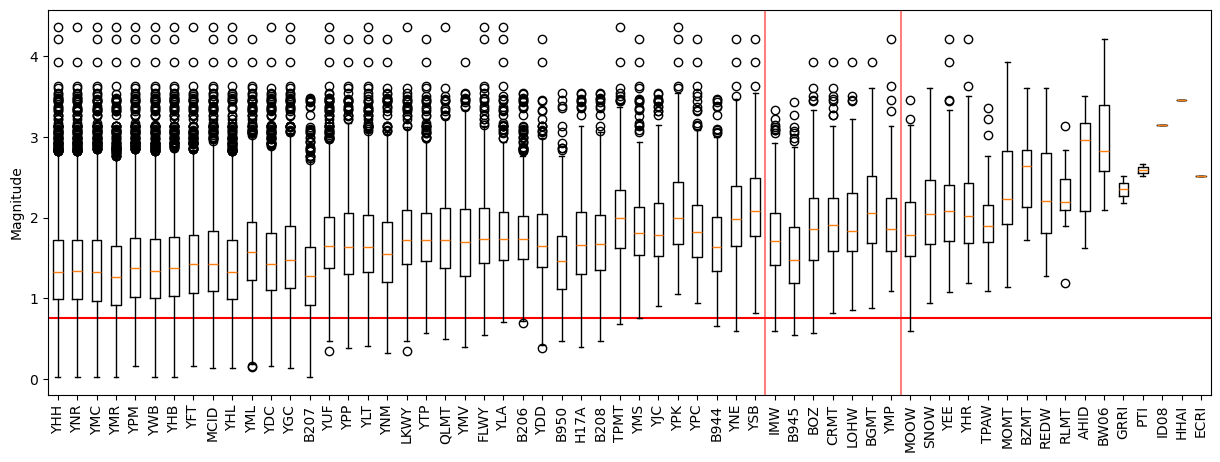

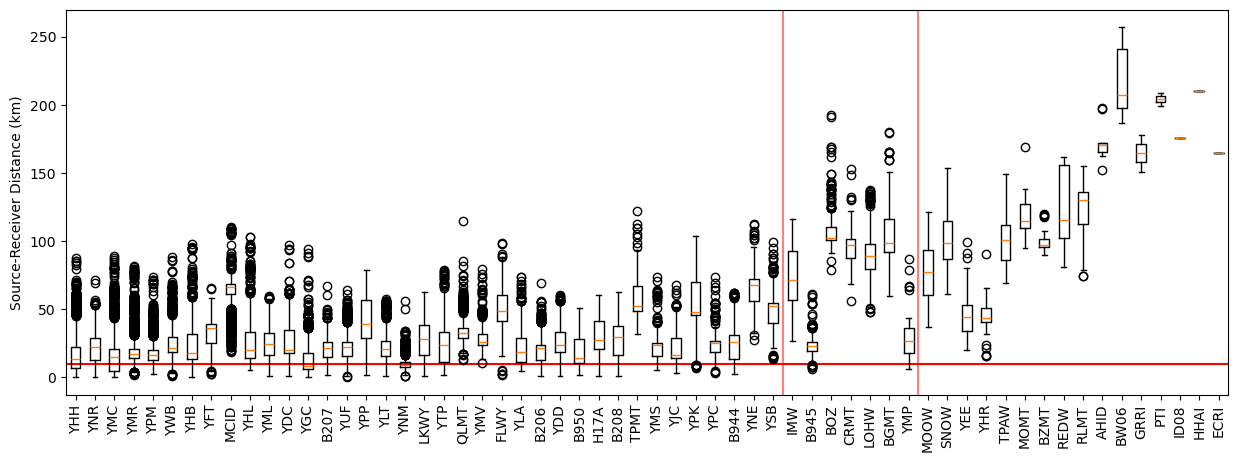

In [23]:
featplot.plot_station_feature_box_whisker(p_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=0.75)
featplot.plot_station_feature_box_whisker(p_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

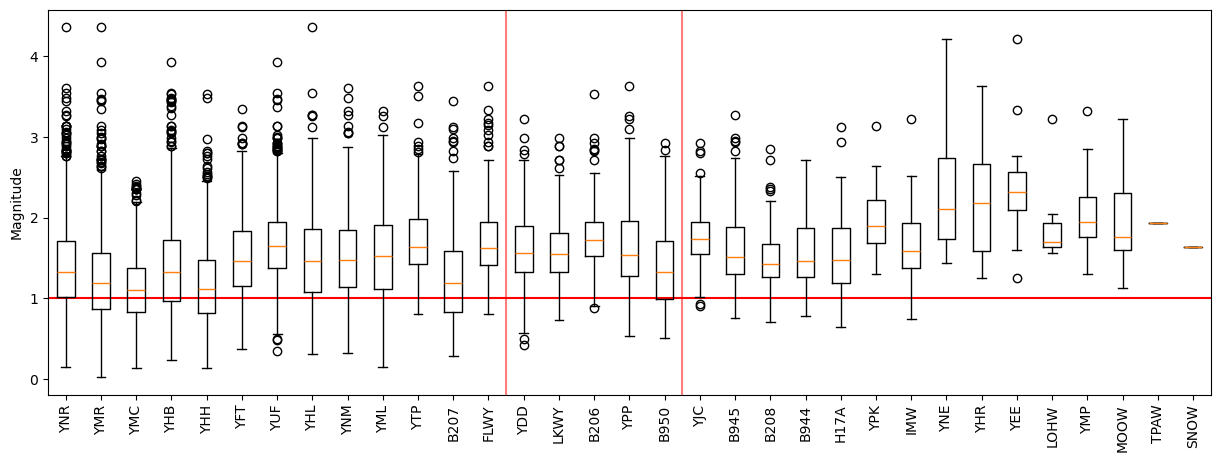

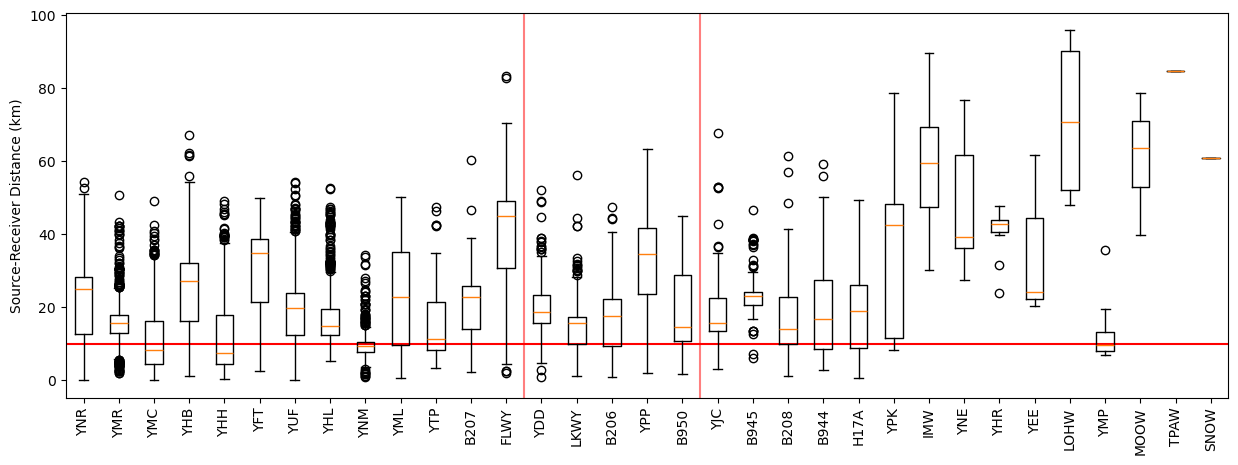

In [24]:
featplot.plot_station_feature_box_whisker(s_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=1.0)
featplot.plot_station_feature_box_whisker(s_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

In [25]:
p_counts_evid = sf.get_station_train_test_counts(p_train_feats, p_test_feats)
s_counts_evid = sf.get_station_train_test_counts(s_train_feats, s_test_feats)

p_good_stats_evid = sf.get_stations_with_min_examples(p_counts_evid, p_min_train, p_min_test)
s_good_stats_evid = sf.get_stations_with_min_examples(s_counts_evid, s_min_train, s_min_test, 'S')

p_almost_stats_evid = sf.get_stations_close_to_criteria(p_counts_evid, p_min_train, p_min_test)
s_almost_stats_evid = sf.get_stations_close_to_criteria(s_counts_evid, s_min_train, s_min_test, 'S')

P stations meeting the min. criteria: 37
S stations meeting the min. criteria: 18
P stations close to min. criteria: 0
S stations close to min. criteria: 0


In [26]:
p_almost_stats_evid

,station,cnt_train,cnt_test


In [27]:
sf.get_station_feature_time_span(p_feats, p_almost_stats_evid, ev_cat)

,event_identifier,arrival_identifier,network,station,channel,location_code,source_latitude,source_longitude,source_receiver_distance_km,source_receiver_back_azimuth,...,avg_noise_15.00,avg_signal_15.00,avg_noise_16.00,avg_signal_16.00,avg_noise_17.00,avg_signal_17.00,avg_noise_18.00,avg_signal_18.00,Evid,Event-Mean-YPML-S
station,,,,,,,,,,,,,,,,,,,,,


In [28]:
sf.get_station_feature_time_span(s_feats, s_almost_stats_evid, ev_cat)

,event_identifier,arrival_identifier,network,station,channel1,channel2,location_code,source_latitude,source_longitude,source_receiver_distance_km,...,transverse_avg_noise_17.00,transverse_avg_signal_17.00,radial_avg_noise_17.00,radial_avg_signal_17.00,transverse_avg_noise_18.00,transverse_avg_signal_18.00,radial_avg_noise_18.00,radial_avg_signal_18.00,Evid,Event-Mean-YPML-S
station,,,,,,,,,,,,,,,,,,,,,


I am going to move forward with the event-based train-test split with 2023 heldout in a separate dataset. This method results in the more stations with potentially viable models, which is better for historical catalogs, than just the temporal train-test split at 2020/7/1. Having a small temporal, heldout dataset will allow for a better analysis of the how the method would do in a real-time system. So, this approach strikes a nice balance between building historical earthquake catalogs and developing a method to use for new data. 

In [29]:
p_train_filt = sf.filter_feature_stations(p_train_feats, p_good_stats_evid)
p_test_filt = sf.filter_feature_stations(p_test_feats, p_good_stats_evid)

Original P size: 68697 (60 stations) 
Filtered P size: 66425 (37 stations)
Original P size: 17403 (58 stations) 
Filtered P size: 16879 (37 stations)


In [30]:
s_train_filt = sf.filter_feature_stations(s_train_feats, s_good_stats_evid, phase='S')
s_test_filt = sf.filter_feature_stations(s_test_feats, s_good_stats_evid, phase='S')

Original S size: 13390 (33 stations) 
Filtered S size: 12738 (18 stations)
Original S size: 3507 (33 stations) 
Filtered S size: 3327 (18 stations)


# Filter by station lat and lon

In [31]:
stat_info = pd.read_csv(f'{data_path}/stat.info.csv')
stat_info.head()

,network,station,receiver_lat,receiver_lon
0,WY,YHB,44.75080,-111.19620
1,WY,YHH,44.78833,-110.85050
2,WY,YDC,44.70950,-111.23967
3,WY,YMR,44.66867,-110.96500
4,PB,B207,44.61900,-110.84850


In [32]:
np.any(stat_info.duplicated('station'))

False

In [33]:
p_good_stats = sf.filter_good_stations_by_location(p_good_stats_evid, stat_info, 44, 45.1, -111.4, -109.8)
p_good_stats.shape

Started with 37 stations
Now have 35 stations


(35, 6)

In [34]:
s_good_stats = sf.filter_good_stations_by_location(s_good_stats_evid, stat_info, 44, 45.1, -111.4, -109.8)
s_good_stats.shape

Started with 18 stations
Now have 18 stations


(18, 6)

In [35]:
s_good_stats

,station,cnt_train,cnt_test,network,receiver_lat,receiver_lon
0,YNR,2090.0,541.0,WY,44.715500,-110.679170
1,YMR,1533.0,392.0,WY,44.668670,-110.965000
2,YMC,1443.0,363.0,WY,44.759330,-111.006160
3,YHB,1248.0,331.0,WY,44.750800,-111.196200
4,YHH,1222.0,328.0,WY,44.788330,-110.850500
5,YFT,899.0,214.0,WY,44.451330,-110.835830
6,YUF,816.0,227.0,WY,44.712600,-110.511700
7,YHL,537.0,133.0,WY,44.850900,-111.183000
8,YNM,487.0,137.0,WY,44.726500,-110.703700
9,YML,423.0,126.0,WY,44.605330,-110.643170


In [36]:
p_good_stats_evid

,station,cnt_train,cnt_test
37,YHH,4813,1215.0
51,YNR,4649,1174.0
43,YMC,4322,1110.0
46,YMR,4154,1071.0
54,YPM,4078,1018.0
59,YWB,3780,913.0
36,YHB,3580,897.0
34,YFT,3529,920.0
21,MCID,3389,832.0
38,YHL,3213,812.0


In [37]:
p_counts

,station,cnt_train,cnt_test
37,YHH,5019.0,1406.0
51,YNR,4997.0,1101.0
43,YMC,4445.0,1447.0
46,YMR,4247.0,1424.0
54,YPM,4118.0,1416.0
...,...,...,...
14,GRRI,2.0,NaN
12,ECRI,2.0,NaN
17,ID08,1.0,NaN
60,ECMT,NaN,27.0


In [38]:
evid_split_max_time.strftime("%Y%m%d")

'20230101'

In [39]:
s_feats_temporal = s_feats[s_feats.event_identifier.isin(s_heldout)]

In [41]:
sf.add_station_holdout_counts(s_feats_temporal, s_counts)

,station,cnt_train,cnt_test,cnt_holdout
0,YNR,2199.0,531.0,99.0
1,YMR,1604.0,493.0,172.0
2,YMC,1552.0,425.0,171.0
3,YHB,1173.0,631.0,225.0
4,YHH,1071.0,592.0,113.0
5,YFT,932.0,236.0,55.0
6,YUF,799.0,362.0,118.0
7,YHL,631.0,78.0,39.0
8,YML,538.0,18.0,7.0
9,YTP,463.0,72.0,49.0
